In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded, _ = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
            
def get_weapon_data():
    return weapons.get_data(2, 13, 0)

In [4]:
network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=26,
         n_hidden_2=12,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = tf.nn.elu
num_epochs = 70
batch_size = 4
epoch_debug_step = 1
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001 - Cost:22.564115029
Epoch:0002 - Cost:17.606869345
Epoch:0003 - Cost:16.559788441
Epoch:0004 - Cost:14.914163184
Epoch:0005 - Cost:14.993014779
Epoch:0006 - Cost:14.634663424
Epoch:0007 - Cost:14.582165696
Epoch:0008 - Cost:11.505556122
Epoch:0009 - Cost:13.799359870
Epoch:0010 - Cost:11.880904956
Epoch:0011 - Cost:12.483304136
Epoch:0012 - Cost:11.089303009
Epoch:0013 - Cost:12.913107114
Epoch:0014 - Cost:11.512494290
Epoch:0015 - Cost:10.581362942
Epoch:0016 - Cost:11.683639782
Epoch:0017 - Cost:10.400852429
Epoch:0018 - Cost:12.107261147
Epoch:0019 - Cost:10.118913245
Epoch:0020 - Cost:11.298225974
Epoch:0021 - Cost:10.898118732
Epoch:0022 - Cost:9.702796365
Epoch:0023 - Cost:10.168508995
Epoch:0024 - Cost:10.528818311
Epoch:0025 - Cost:10.344547737
Epoch:0026 - Cost:10.064771412
Epoch:0027 - Cost:11.318472569
Epoch:0028 - Cost:10.046714122
Epoch:0029 - Cost:10.491924797
Epoch:0030 - Cost:9.926897094
Epoch:0031 - Cost:9.935223452
Epoch:0032 - Cost:9.643910055
Epoch:0033 -

In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    train_data, test_data = get_weapon_data()
    samples = test_data.next_batch(batch_size)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[ 0.82948142  0.60118691  2.88712045  0.99569425 -1.04880885  1.58113883
  -0.48507125 -1.32959555  0.82220467 -0.26424317 -0.85685916  0.4513875
  -0.57240795 -0.48010721 -0.97777561 -0.32444284 -0.32444284 -0.48507125
   1.78885438 -0.32444284 -0.40824829 -0.55901699]
 [ 0.0666007  -0.24819643 -0.37647957 -0.18180478  0.95346259 -0.63245553
  -0.48507125  1.19705471 -0.48703846 -0.51801329 -0.92760898 -0.23089207
  -0.52832274 -0.1651308   0.39585861 -0.32444284 -0.32444284 -0.48507125
  -0.55901699  3.082207   -0.40824829 -0.55901699]
 [-0.51827452 -0.17097976 -0.318201   -0.51823307  0.95346259 -0.63245553
  -0.48507125  0.18639461 -1.28305835 -0.67704257  0.98263667  0.90624054
  -0.21972628 -0.1651308   0.40094614 -0.32444284 -0.32444284 -0.48507125
  -0.55901699 -0.32444284 -0.40824829  1.78885438]
 [ 2.20266672  2.76325362 -0.95926529  1.72462221 -1.04880885 -0.63245553
   2.06155281 -0.57160047  1.08405337  0.92

In [6]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    avg_cost_rand = 0.
    avg_cost = 0.
    avg_distance_norm = 0.
    avg_distance_unnorm = 0.

    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples

    for i in range(num_samples):
        batch = test_data.next_batch(batch_size)

        x_reconstructed = network.encode_and_decode(batch)
        cost = network.calculate_loss(batch)

        _, unstandardized_batch = test_data.decode_processed_tensor(batch[0])
        _, unstandardized_x = test_data.decode_processed_tensor(x_reconstructed[0])

        distance_unnorm = tf.reduce_sum(tf.abs(unstandardized_batch - unstandardized_x))
        distance_norm = tf.reduce_sum(tf.abs(batch[0] - x_reconstructed[0]))

        distance_unnorm, distance_norm = sess.run((distance_unnorm, distance_norm))

        sample = np.random.uniform(low=test_data.standardized_min_values, 
                                   high=test_data.standardized_max_values, 
                                   size=(batch_size,network_architecture["n_input"]))
        cost_rand = network.calculate_loss(sample)
        print("Random Cost = " + "{:.3f}".format(cost_rand))

        #compute average loss/cost
        avg_cost_rand += min(cost_rand,1000) / num_samples
        avg_cost += cost / num_samples
        avg_distance_unnorm += distance_unnorm / num_samples
        avg_distance_norm += distance_norm / num_samples
    
    print("random input Average cost = " + "{:.9f}".format(avg_cost_rand))   
    print("Average cost = " + "{:.9f}".format(avg_cost))
    print("Average unnormalized distance = " + "{:.9f}".format(avg_distance_unnorm))
    print("Average normalized distance = " + "{:.9f}".format(avg_distance_norm))


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Random Cost = 318834173088342231482368.000
Random Cost = 3518399209761344061440.000
Random Cost = 2176358749689769623552.000
Random Cost = 63702484484032800227328.000
Random Cost = 1420002976908426870784.000
Random Cost = 145247483094169362104320.000
Random Cost = 743508148224.000
Random Cost = 15928585828609279850014834688.000
Random Cost = 36020583667104481280.000
Random Cost = 623782559575199597985792.000
Random Cost = 51499299283927040.000
Random Cost = 41157215603654656.000
Random Cost = 50208380301624786580144128.000
Random Cost = 154936508416.000
Random Cost = 3898615889777074896896.000
Random Cost = 845532111952859365376.000
Random Cost = 1656633981665280.000
Random Cost = 936273874207352291328.000
Random Cost = 17112514201194070016.000
Random Cost = 646576538297217341980672.000
Random Cost = 2544354208429188841472.000
random input Average cost = 1000.000000000
Average cost = 10.742467767
Average unnormalized dist

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


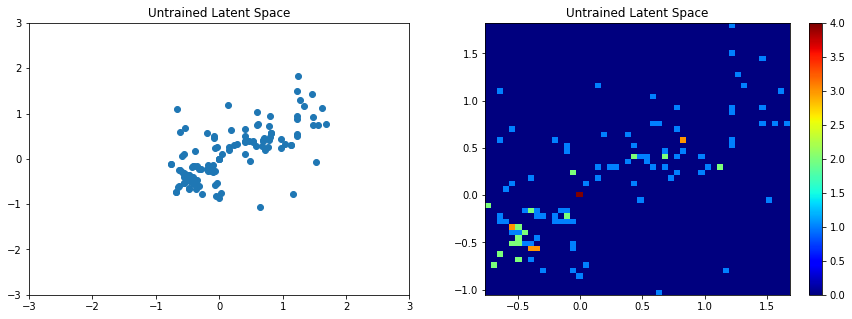

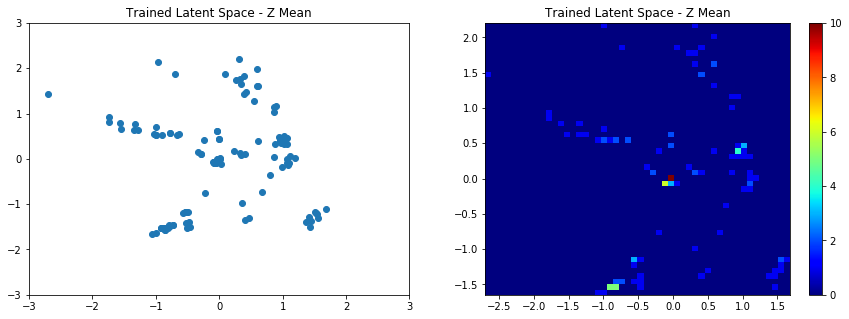

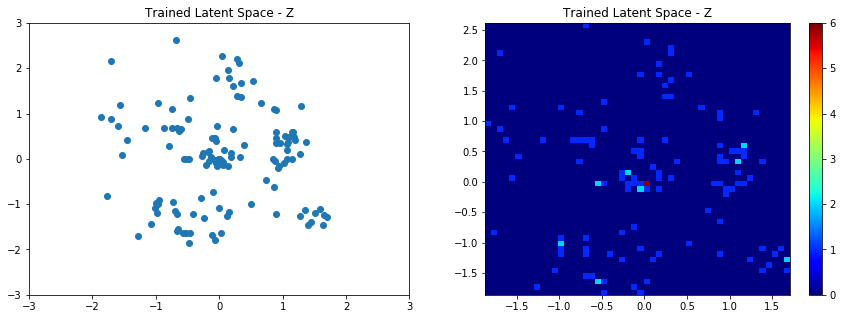

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((batch_size,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space - Z Mean", z_mean=True)    
    show_z_distribution(network, "Trained Latent Space - Z", z_mean=False)

In [8]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(batch_size,network_architecture["n_z"]))
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['36.2697036666592', '26.361972672119357', '44.45714355864933', '26.268190465609514']
damages_last = ['16.667544281887796', '21.936292685804798', '17.29070045882394', '16.695934998054142']
dmg_distances_first = ['10.926951738625284', '16.26409175502747', '7.522615594973017', '16.901495200894033']
dmg_distances_last = ['34.72098742510346', '49.27829262276761', '29.759272258961907', '36.172670589955615']
firemode_Automatic = ['0.10399126674583362', '0.9668386727262663', '-0.10582061928802555', '0.9586518887780422']
firemode_Semi-Automatic = ['0.9286150145333654', '-0.019269769920635504', '1.0400576571862006', '-0.023516228943109452']
hiprecoildec = ['5.0753351885973625', '5.888362643302527', '4.7961816497786165', '7.0583993098218']
hiprecoilright = ['0.4546846798193124', '0.2744535258394834', '0.6482277769865162', '0.24222363886747755']
hiprecoilup = ['1.6207557326016795', '0.8647473700243626', '3.0535618203